# Infrastructure

## Partie 1 : Downloading data

In [1]:
import re
import requests
from urllib import request
import gzip, shutil
import numpy as np
import os

os.environ["SPARK_HOME"] = "/opt/spark"
os.environ["PYSPARK_PYTHON"]="/home/mocmoc/anaconda3/bin/python3"

def extract_file(url: str) -> list[str]:
    file_list = []
    trace_xml = requests.get(url)
    trace_filenames = re.findall(r'<Key>(.*?)</Key>', trace_xml.text)
    for trace_filename in trace_filenames:
        file_list.append(f"{url}/{trace_filename}")
    return file_list


def download_url(trace_url: str) -> str:
    trace_filename = f"{trace_url.split('/')[-2]}_{trace_url.split('/')[-1]}"
    if os.path.exists(trace_filename) or os.path.exists(trace_filename.replace(".gz", "")):
        try:
            os.remove(trace_filename)
        except:
            pass
        return
    
    print(f"Downloading of {trace_filename}")
    request.urlretrieve(
                url=trace_url,
                filename=trace_filename
        )
    return trace_filename

def unzip_file(file: str):
    path = file.replace(".gz", "")
    
    if os.path.exists(path):
        
        return
    with gzip.open(file, 'r') as f_in, open(file.replace(".gz", ""), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(file)

In [2]:
GCS_URI = "https://storage.googleapis.com"
DATASET_NAME = "clusterdata_2019_schema"

In [3]:
for file in extract_file(f"{GCS_URI}/{DATASET_NAME}"):
    print(file)
    download_url(file)

https://storage.googleapis.com/clusterdata_2019_schema/collection_events.schema.json
https://storage.googleapis.com/clusterdata_2019_schema/instance_events.schema.json
https://storage.googleapis.com/clusterdata_2019_schema/instance_usage.schema.json
https://storage.googleapis.com/clusterdata_2019_schema/machine_attributes.schema.json
https://storage.googleapis.com/clusterdata_2019_schema/machine_events.schema.json


In [4]:
# https://storage.googleapis.com/clusterdata_2019_a/collection_events-000000000001.json.gz
# ...GCS_URI.../...DATASET_NAME..._...dataset_letter.../...COLLECTION_NAME...event_number...FILE_EXTENSION
GCS_URI = "https://storage.googleapis.com"
DATASET_NAME = "clusterdata_2019"
DATASET_LETTERS = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [5]:
trace_list = []
for letter in DATASET_LETTERS:
    trace_url = f"{GCS_URI}/{DATASET_NAME}_{letter}"
    letter_trace_url = extract_file(trace_url)
    trace_list.extend(letter_trace_url)

In [6]:
collection_a = [trace_url for trace_url in trace_list if ("collection" in trace_url) and ("clusterdata_2019_a" in trace_url)]
instance_a = [trace_url for trace_url in trace_list if ("instance" in trace_url) and ("clusterdata_2019_a" in trace_url)]
usage_a = [trace_url for trace_url in trace_list if ("usage" in trace_url) and ("clusterdata_2019_a" in trace_url)]

In [7]:
# downloading files
for trace_url in collection_a[:7]:
        download_url(trace_url)

for trace_url in instance_a[:7]:
        download_url(trace_url)

for trace_url in usage_a[:7]:
        download_url(trace_url)

Initialize Spark

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .master("spark://192.168.1.93:7077")\
    .appName("PROJET_INFRA")\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/25 21:55:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
spark

## Partie 2 : Loading data

### 2.1 Instance Usage

On créé le schéma :

In [10]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType, ArrayType, DoubleType
from pyspark.ml.linalg import VectorUDT

data_schemaUsage = StructType([ \
    StructField("start_time",             StringType(), True), \
      #TimestampType()
    StructField("end_time",               StringType(), True), \
      #TimestampType()
    StructField("collection_id",          StringType(), True), \
      #IntegerType()
    StructField("instance_index",         StringType(), True), \
      #IntegerType()
    StructField("machine_id",             StringType(), True), \
      #IntegerType()
    StructField("alloc_collection_id",    StringType(), True), \
      #IntegerType()
    StructField("alloc_instance_index",   StringType(), True), \
      #IntegerType()
    StructField("collection_type",        StringType(), True), \
      #IntegerType()
    StructField("average_usage",          StructType([\
                                                StructField("cpus", FloatType(), True), \
                                                StructField("memory", FloatType(), True), \
                                              ]), True), \
    StructField("maximum_usage",          StructType([\
                                                StructField("cpus", FloatType(), True), \
                                                StructField("memory", FloatType(), True), \
                                              ]), True), \
    StructField("random_sample_usage",    StructType([\
                                                StructField("cpus", FloatType(), True), \
                                                StructField("memory", FloatType(), True), \
                                              ]), True), \
    StructField("assigned_memory",        FloatType(), True), \
    StructField("page_cache_memory",      FloatType(), True), \
    StructField("cycles_per_instruction", FloatType(), True), \
    StructField("memory_accesses_per_instruction", FloatType(), True), \
    StructField("sample_rate",            FloatType(), True), \
    StructField("cpu_usage_distribution", ArrayType(DoubleType()), True), \
    StructField("tail_cpu_usage_distribution", ArrayType(DoubleType()), True), \
  ])

On charge le fichier .json correspondant :

In [11]:
path = "clusterdata_2019_a_" + "instance_usage-000000000000.json"

dfUsage = spark.read\
    .format("json")\
    .schema(data_schemaUsage)\
    .load(path)

Certaines variables contiennent des dictionnaires ayant comme clefs : `cpus` et `memory`. Ainsi, on créé de nouvelles variables contenant la valeur de ces clefs :

In [12]:
dfUsage = dfUsage\
                .withColumn("random_sample_memory_usage", dfUsage.random_sample_usage.getItem("memory"))\
                .withColumn("random_sample_cpu_usage", dfUsage.random_sample_usage.getItem("cpus"))\
                .withColumn("average_memory_usage", dfUsage.average_usage.getItem("memory"))\
                .withColumn("average_cpu_usage", dfUsage.average_usage.getItem("cpus"))\
                .withColumn("maximum_memory_usage", dfUsage.maximum_usage.getItem("memory"))\
                .withColumn("maximum_cpu_usage", dfUsage.maximum_usage.getItem("cpus"))\
                .drop("maximum_usage")\
                .drop("average_usage")\
                .drop("random_sample_usage")

On transforme le type des variables vers les bons (Google donne par défaut des `strings`) :

In [13]:
from pyspark.sql import Column
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

dfUsage = dfUsage\
    .na.drop(how="any", subset=["memory_accesses_per_instruction"])\
    .na.drop(how="any", subset=["cpu_usage_distribution"])\
    .na.drop(how="any", subset=["tail_cpu_usage_distribution"])\
    .filter(F.size(F.col("cpu_usage_distribution")) >= 1)\
    .filter(F.size(F.col("tail_cpu_usage_distribution")) >= 1)\

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

dfUsage = dfUsage\
    .withColumn("start_time", dfUsage.start_time.cast('double'))\
    .withColumn("end_time", dfUsage.end_time.cast('double'))\
    .withColumn("collection_id", dfUsage.collection_id.cast('double'))\
    .withColumn("instance_index", dfUsage.instance_index.cast('double'))\
    .withColumn("machine_id", dfUsage.machine_id.cast(IntegerType()))\
    .withColumn("alloc_collection_id", dfUsage.alloc_collection_id.cast('double'))\
    .withColumn("alloc_instance_index", dfUsage.alloc_instance_index.cast('double'))\
    .withColumn("collection_type", dfUsage.collection_type.cast('int'))\
    .withColumn("cpu_usage_distribution", list_to_vector_udf(dfUsage["cpu_usage_distribution"]))\
    .withColumn("tail_cpu_usage_distribution", list_to_vector_udf(dfUsage["tail_cpu_usage_distribution"]))\
        
dfUsage = dfUsage\
    .withColumn("duration", dfUsage.end_time-dfUsage.start_time)

Vérification :

In [14]:
'string' in np.array(dfUsage.dtypes)[:,1]

False

### 2.2 Instance Events

On répète la même procédure que la partie précédente :

In [15]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType, ArrayType, DoubleType
from pyspark.ml.linalg import VectorUDT

data_schemaEvents = StructType([ \
    StructField("time",             StringType(), True), \
      #TimestampType()
    StructField("type",               StringType(), True), \
      #TimestampType()
    StructField("collection_id",          StringType(), True), \
      #IntegerType()    
    StructField("machine_id",        StringType(), True), \
    StructField("scheduling_class",         StringType(), True), \
      #IntegerType()
    StructField("missing_type",             StringType(), True), \
      #IntegerType()
    StructField("collection_type",    StringType(), True), \
      #IntegerType()
    StructField("priority",   StringType(), True), \
      #IntegerType()
    StructField("alloc_collection_id",        StringType(), True), \
      #IntegerType()
    
    StructField("instance_index",        StringType(), True), \
    StructField("alloc_instance_index",        StringType(), True), \
    StructField("resource_request",        StructType([\
                                                StructField("cpus", FloatType(), True), \
                                                StructField("memory", FloatType(), True), \
                                              ]), True), \
    StructField("constraint",        StringType(), True)
  ])

In [16]:
path = "clusterdata_2019_a_" + "instance_events-000000000000.json"

dfEvents = spark.read\
    .format("json")\
    .schema(data_schemaEvents)\
    .load(path)

In [17]:
dfEvents = dfEvents\
                .withColumn("memory_request", dfEvents.resource_request.getItem("memory"))\
                .withColumn("cpu_request", dfEvents.resource_request.getItem("cpus"))\
                .drop("resource_request")

In [18]:
dfEvents.dtypes

[('time', 'string'),
 ('type', 'string'),
 ('collection_id', 'string'),
 ('machine_id', 'string'),
 ('scheduling_class', 'string'),
 ('missing_type', 'string'),
 ('collection_type', 'string'),
 ('priority', 'string'),
 ('alloc_collection_id', 'string'),
 ('instance_index', 'string'),
 ('alloc_instance_index', 'string'),
 ('constraint', 'string'),
 ('memory_request', 'float'),
 ('cpu_request', 'float')]

In [19]:
dfEvents = dfEvents\
    .withColumn("time", dfEvents.time.cast('double'))\
    .withColumn("type", dfEvents.type.cast('double'))\
    .withColumn("collection_id", dfEvents.collection_id.cast('double'))\
    .withColumn("machine_id", dfEvents.machine_id.cast(IntegerType()))\
    .withColumn("scheduling_class", dfEvents.scheduling_class.cast('double'))\
    .withColumn("missing_type", dfEvents.missing_type.cast('double'))\
    .withColumn("collection_type", dfEvents.collection_type.cast('double'))\
    .withColumn("priority", dfEvents.priority.cast('double'))\
    .withColumn("alloc_collection_id", dfEvents.alloc_collection_id.cast('int'))\
    .withColumn("instance_index", dfEvents.instance_index.cast('int'))\
    .withColumn("alloc_instance_index", dfEvents.alloc_instance_index.cast('int'))\
    .withColumn("constraint", dfEvents.constraint.cast('int'))

In [20]:
'string' in np.array(dfEvents.dtypes)[:,1]

False

### 2.3 Machine Attributes

In [21]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType, ArrayType, DoubleType
from pyspark.ml.linalg import VectorUDT

data_schemaMachines_attributes = StructType([ \
    StructField("time",             StringType(), True), \
    StructField("machine_id",        StringType(), True), \
    StructField("name",         StringType(), True), \
    StructField("value",             StringType(), True), \
    StructField("deleted",    StringType(), True), \
  ])

In [22]:
path = "machine_attributes-000000000000.json"

dfMachine_attributes = spark.read\
    .format("json")\
    .schema(data_schemaMachines_attributes)\
    .load(path)

In [23]:
dfMachine_attributes = dfMachine_attributes\
    .withColumn("time", dfMachine_attributes.time.cast('double'))\
    .withColumn("machine_id", dfMachine_attributes.machine_id.cast(IntegerType()))\
    .withColumn("value", dfMachine_attributes.value.cast('double'))\
    .withColumn("deleted", dfMachine_attributes.deleted.cast('boolean'))

### 2.4 Machine Events

In [24]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType, ArrayType, DoubleType
from pyspark.ml.linalg import VectorUDT

data_schemaMachines_events = StructType([ \
    StructField("time",             StringType(), True), \
    StructField("machine_id",        StringType(), True), \
    StructField("type",         StringType(), True), \
    StructField("switch_id",             StringType(), True), \
    StructField("capacity",        StructType([\
                                                StructField("cpus", FloatType(), True), \
                                                StructField("memory", FloatType(), True), \
                                              ]), True), \
    StructField("platform_id",             StringType(), True), \
    StructField("missing_data_reason",             StringType(), True), \
  ])

In [25]:
path = "machine_events-000000000000.json"

dfMachine_events = spark.read\
    .format("json")\
    .schema(data_schemaMachines_events)\
    .load(path)

In [26]:
dfMachine_events = dfMachine_events\
                .withColumn("memory_capacity", dfMachine_events.capacity.getItem("memory"))\
                .withColumn("cpu_capacity", dfMachine_events.capacity.getItem("cpus"))\
                .drop("capacity")

In [27]:
dfMachine_events = dfMachine_events\
    .withColumn("time", dfMachine_events.time.cast('double'))\
    .withColumn("type", dfMachine_events.type.cast('double'))\
    .withColumn("switch_id", dfMachine_events.switch_id.cast('double'))\
    .withColumn("machine_id", dfMachine_events.machine_id.cast('double'))\
    .withColumn("platform_id", dfMachine_events.platform_id.cast('double'))

## Partie 3 : Data Transformation and Exploration

### 3.1 Creating new variables

Maintenant que les données sont chargées dans leur dataframes respectifs. On peut fusionner `dfUsage` et `dfEvents` selon les clefs communes suivantes : `collection_id`, `instance_index`, `machine_id`, `alloc_collection_id`, `alloc_instance_index`, `collection_type`:

In [28]:
# merging dataframes by id
dfMerged = dfUsage.join(dfEvents, on=["collection_id", "instance_index", "machine_id", "alloc_collection_id", "alloc_instance_index", "collection_type"]).distinct()

On va créer également une nouvelle variable qui correspond au ratio entre `maximum_cpu_usage` et `cpu_request` (pareil mais avec `memory` au lieu de `cpu`). On appellera ces nouvelles variables : `ratio_cpu_waste` et `ratio_memory_waste`. 

Par exemple : 
$$
\text{ratio cpu waste} = 1 - \frac{\text{maximum cpu usage}}{\text{requested cpu}}
$$

In [29]:
dfMerged = dfMerged\
                .withColumn("ratio_memory_waste", 
                                1-dfMerged.maximum_memory_usage/dfMerged.memory_request)

In [30]:
dfMerged = dfMerged\
                .withColumn("ratio_cpu_waste", 
                                1-dfMerged.maximum_cpu_usage/dfMerged.cpu_request)

### 3.2 Transformation des données

Dans le dataframe `dfMerged`, on a deux variables correspondantes à des distributions : `cpu_usage_distribution`, `tail_cpu_usage_distribution`. Ces variables ne sont pas vraiment utilisables telles quelles. Ainsi, on va créer deux autres nouvelles variables catégoriques pour les remplacer : 
- `cpu_workload`

Ces deux variables sont catégoriques et prennent les valeurs suivantes : `high`, `medium` et `low`, représentant l'intensité de la tâche sur le processeur et la mémoire.

Pour faire cette transformation, on utilise une classification `K-means`.

In [31]:
# importation des librairies
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler

In [32]:
# Vectorisation des données
data_usage_distri = VectorAssembler(
    inputCols = [
        "cpu_usage_distribution"
    ],
    outputCol = "features"
)

data_usage_distri = data_usage_distri.transform(dfMerged)

22/06/25 21:56:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [33]:
# Y A PAS BESOIN DE CA
# Standardisation des données
scale = StandardScaler(inputCol='features', outputCol='standardized')
data_scale = scale.fit(data_usage_distri)

data_usage_distri_scaled = data_scale.transform(data_usage_distri)

In [36]:
# Application du K-means. On prend k = 3
from pyspark.ml.evaluation import ClusteringEvaluator

KMeans_algo = KMeans(featuresCol = 'standardized', k = 3)

KMeans_fit = KMeans_algo.fit(data_usage_distri_scaled)
output = KMeans_fit.transform(data_usage_distri_scaled)

In [37]:
dfMerged = output

In [ ]:
# evaluator = ClusteringEvaluator(predictionCol = 'prediction',
#                                 featuresCol = 'standardized',
#                                 metricName = 'silhouette',
#                                 distanceMeasure = 'squaredEuclidean')

# dfMerged = output.drop("features", "standardized", "cpu_usage_distribution")
            
# score=evaluator.evaluate(output)

# print("Silhouette Score:",score)

Le score est plutôt très bon. On va visualiser les clusters à l'aide d'une Analyse par Composante Principales (pour réduire la dimension) :

In [41]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=2, inputCol="standardized", outputCol="pca")
pca_model = pca.fit(dfMerged)
pca_transformed = pca_model.transform(dfMerged)

22/06/25 22:52:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/06/25 22:52:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [43]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [44]:
cluster_assignment = np.array(output.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

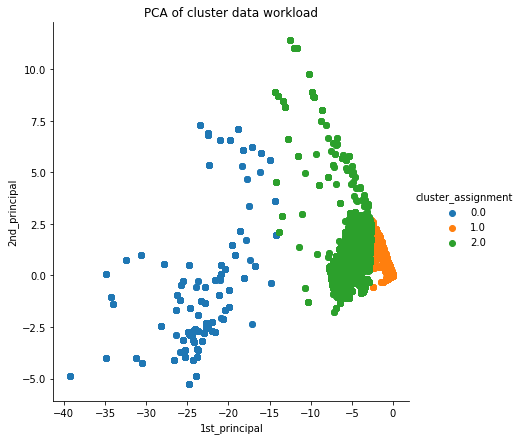

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pca_data = np.hstack((x_pca, cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.title("PCA of cluster data workload")

plt.show()

In [51]:
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [55]:
dfKmeans = dfMerged.toPandas()

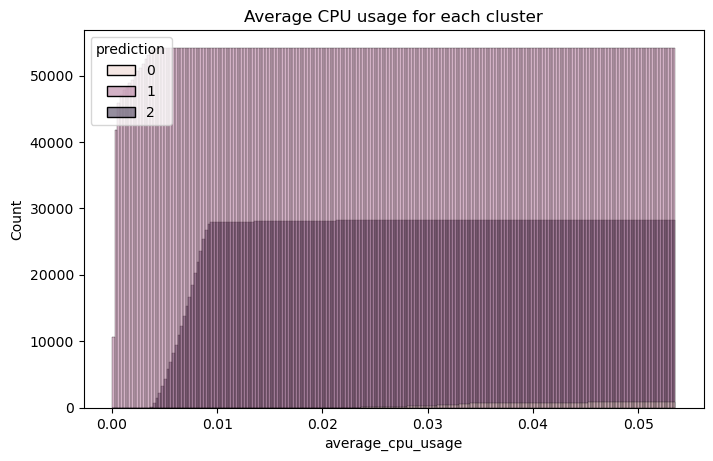

In [70]:
figure(figsize=(8, 5), dpi=100)
sns.histplot(data=dfKmeans, x='average_cpu_usage', hue='prediction', cumulative=True)

plt.title('Average CPU usage for each cluster')
plt.show()

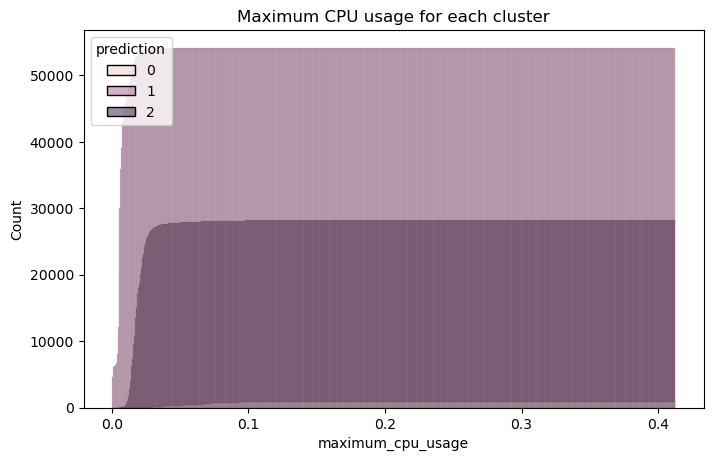

In [64]:
figure(figsize=(8, 5), dpi=100)
sns.histplot(data=dfKmeans, x='maximum_cpu_usage', hue='prediction', cumulative=True)
plt.title('Maximum CPU usage for each cluster')
plt.show()

### 3.3 CPU and Memory capacities of machines

In [83]:
# sorting Events by time
dfMachine_events = dfMachine_events.sort('time', ascending=True)# 
dfEvents = dfEvents.sort('time', ascending=True)

In [95]:
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

#### 3.3.1 Machine's type

In [114]:
dfMachineType = dfMachine_events.toPandas()

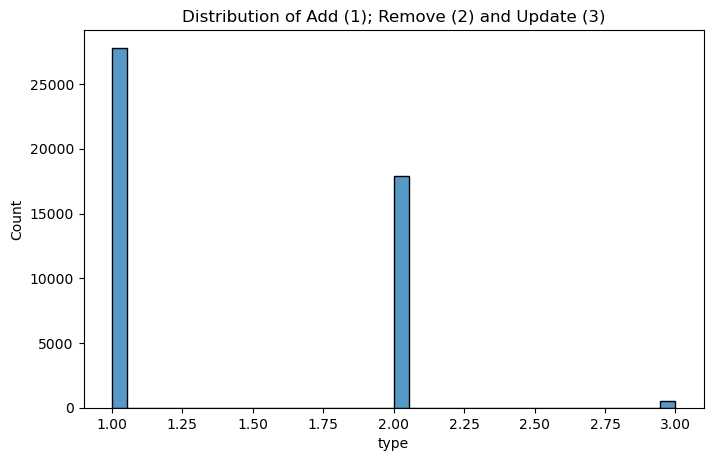

In [115]:
figure(figsize=(8, 5), dpi=100)
sns.histplot(data=dfMachineType, x='type')
plt.title('Distribution of Add (1); Remove (2) and Update (3)')
plt.show()

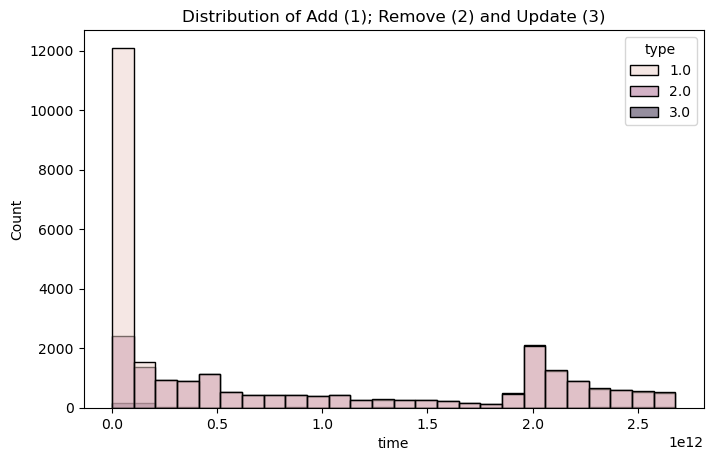

In [116]:
figure(figsize=(8, 5), dpi=100)
sns.histplot(data=dfMachineType, x='time', hue='type')
plt.title('Distribution of Add (1); Remove (2) and Update (3)')
plt.show()

#### 3.3.2 CPU and Memory in machines

In [135]:
dfMachineCapacity = dfMachine_events\
    .where(dfMachine_events.type == 1)\
    .groupBy('cpu_capacity', 'memory_capacity')\
    .count()
# dfMachineCapacity = dfMachineCapacity.withColumnRenamed('avg(memory_capacity)', 'memory_capacity_sum')
dfMachineCapacity = dfMachineCapacity.toPandas()

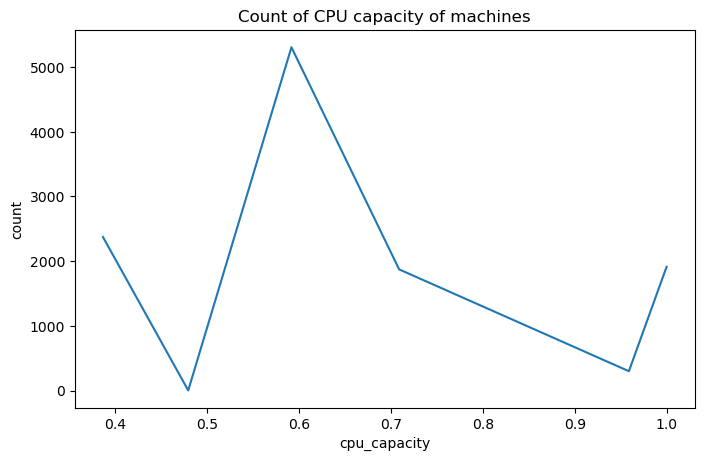

In [140]:
figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=dfMachineCapacity, x='cpu_capacity', y='count', ci=None)
plt.title('Count of CPU capacity of machines')
plt.show()

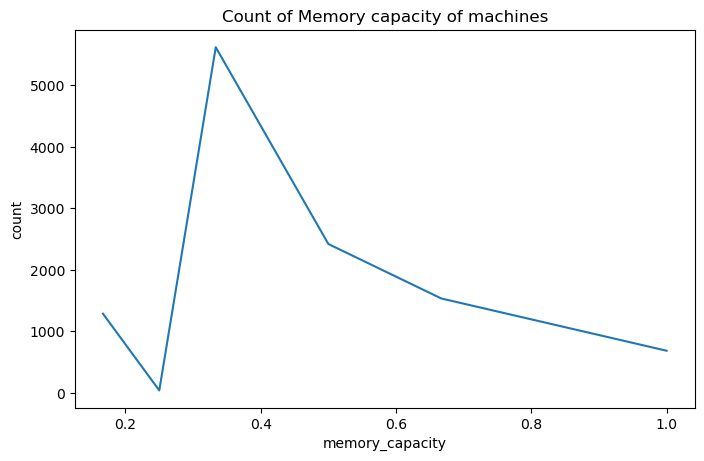

In [141]:
figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=dfMachineCapacity, x='memory_capacity', y='count', ci=None)
plt.title('Count of Memory capacity of machines')
plt.show()

## Partie 4: Our study

## Part X: Scheduling optimization (skip)

Each task is represented by the following variables:
- Time: when the task is created
- Duration: how long the tasks takes from when a machine is allocated to perform the task until it finishes executing it
- Workload: Low, Medium, High - how much CPU the task uses
- CPU_request: how much CPU the task is requesting
- Memory_request: how much memory the task is requesting
- Priority: importance of the task

From now on, we make the following suppositions:
- The CPU_request and memory_request cannot be changed even if the task does not use all the capacity requested

Therefore, we are looking at optimizing the scheduling of tasks throughout the machines.

To do this, we are going to create a waiting list and one executing list for the machines (they are esentially dictionaries)

In [33]:
# sorting Events by time
dfMachine_events = dfMachine_events.sort('time', ascending=True)
dfEvents = dfEvents.sort('time', ascending=True)

In [65]:
def init_lists(machineEvents):
    """
    Function that initializes the model. 
    Input:
        - machineEvents: dataframe of all machines' events 
    Output:
        - wait_list: array representing the waiting list for each task
        - machines: dictionnary : {'machine_id': {'memory': memory_capacity, 'cpu': cpu_capacity}, 
                                                {'task': taskid, 'time': start_time, 'duration': duration},
                                                cpu_request_total, 
                                                memory_request_total }
        - time0: model's starting time
    """

    machineEvents = machineEvents.sort('time', ascending=True)
    
    time0 = machineEvents.select('time').first()[0]
    

    dfMachines = machineEvents.filter((dfMachine_events.time == time0) & (dfMachine_events.type == 1.0)).select('time', 'machine_id', 'memory_capacity', 'cpu_capacity') 

    currentMachinesInfo = [{machine: [{'memory':mem, 'cpu':cpu}, dict.fromkeys(['collection_ids', 'instance_indexes', 'times', 'durations', 'priorities']), 0, 0] for machine, mem, cpu in dfMachines.select('machine_id', 'memory_capacity', 'cpu_capacity').collect()}]

    return currentMachinesInfo[0], time0

In [ ]:
def addTasks(dfTasks, time):
    

In [75]:
dfEvents.sort('time', ascending=True).show(n=1, vertical=True)

-RECORD 0--------------------------------
 time                 | 0.0              
 type                 | 0.0              
 collection_id        | 3.74890160342E11 
 machine_id           | null             
 scheduling_class     | 0.0              
 missing_type         | null             
 collection_type      | 0.0              
 priority             | 0.0              
 alloc_collection_id  | 0                
 instance_index       | 144              
 alloc_instance_index | -1               
 constraint           | null             
 memory_request       | 0.0022888184     
 cpu_request          | 0.0020256042     
only showing top 1 row



In [66]:
# Running simulation
tasks0, machinesRunningInfo0, time0 = init_lists(dfMachine_events, dfMerged)
# currentMachines = list(machinesRunningInfo)

In [72]:
dfMerged.select('collection_id', 'instance_index', 'cpu_request', 'memory_request', 'time').sort('time', ascending=True).show(n=1)

+----------------+--------------+-----------+--------------+---------------+
|   collection_id|instance_index|cpu_request|memory_request|           time|
+----------------+--------------+-----------+--------------+---------------+
|3.75086626207E11|         134.0|0.011352539|  0.0023117065|2.9785076152E10|
+----------------+--------------+-----------+--------------+---------------+
only showing top 1 row



In [64]:
def updateStateMachines(state, MachineEvents, time):
    """
    Function that updates  the state: dictionnary of machines, current_tasks
    """
    dfMachines = MachineEvents.filter(MachineEvents.time == time).select('machine_id', 'time', 'type', 'cpu_capacity', 'memory_capacity')
    
    expiredMachines = dfMachines.filter(dfMachines.type == 2.0).select('machine_id').rdd.flatMap(lambda x: x).collect()

    addedMachines = dfMachines.filter(dfMachines.type == 1.0).drop('type')# .rdd.flatMap(lambda x: x).collect()

    oldTasks, machinesInfo, oldTime = state

    oldMachinesInfo = machinesInfo.copy()
    
    # list of all old machines
    oldMachines = list(oldMachinesInfo)

    # updating MachinesInfo dictionnary
    for expiredMachine in expiredMachines:
        # old machine expired
        # have to gather all the tasks that did not finish
        # remember to update duration
        # as a first approach, kill tasks
        if expiredMachine in oldMachines:
            oldMachinesInfo.pop(expiredMachine)

    newMachinesInfo = [{machine: [{'memory':mem, 'cpu':cpu}, dict.fromkeys(['collection_ids', 'instance_indexes', 'times', 'durations', 'priorities']), 0, 0] for machine, mem, cpu in addedMachines.select('machine_id', 'memory_capacity', 'cpu_capacity').collect()}]

    try:
        currentMachinesInfo = dict(oldMachinesInfo).update(newMachinesInfo)
        currentMachines = list(currentMachinesInfo)
    except:
        currentMachines = list(oldMachinesInfo)
        currentMachinesInfo = oldMachinesInfo

        pass
    print("Old length: ", len(oldMachines), " new length: ", len(currentMachines))

    return oldTasks, currentMachinesInfo, time

In [ ]:
def printState(MachinesInfo):
    

In [36]:
# Running simulation
tasks0, machinesRunningInfo0, time0 = init_lists(dfMachine_events, dfMerged)
# currentMachines = list(machinesRunningInfo)

22/06/19 10:35:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [376]:
# dfMachine_events.filter((dfMachine_events.machine_id == 102892982852.0) & (dfMachine_events.time == 0.0)).select('machine_id', 'type').show()

In [40]:
all_times = dfMachine_events.select('time').distinct().sort('time', ascending=True).rdd.flatMap(lambda x: x).collect()

In [53]:
# running simulation
tasks, times = tasks0, time0
machinesRunningInfo = machinesRunningInfo0.copy()

for time in all_times:
    tasks, machinesRunningInfo, times = updateStateMachines([tasks, machinesRunningInfo, times], dfMachine_events, time=time)
    

[]
Old length:  9526  new length:  9526
[102892982852.0]
Old length:  9526  new length:  9525
[]
Old length:  9525  new length:  9525
[]
Old length:  9525  new length:  9525
[]
Old length:  9525  new length:  9525
[1579832655.0]
Old length:  9525  new length:  9524
[1574329911.0]
Old length:  9524  new length:  9523
[44327628355.0]
Old length:  9523  new length:  9522
[44493424971.0]
Old length:  9522  new length:  9521
[44338119771.0]
Old length:  9521  new length:  9520
[]


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/mocmoc/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/mocmoc/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/mocmoc/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


Old length:  9520  new length:  9520


KeyboardInterrupt: 

In [336]:
dfMachine_events.filter((dfMachine_events.time == 0.0) & (dfMachine_events.machine_id == "102892982852.0")).show(n=10)

+----+----------------+----+---------+-----------+-------------------+---------------+------------+
|time|      machine_id|type|switch_id|platform_id|missing_data_reason|memory_capacity|cpu_capacity|
+----+----------------+----+---------+-----------+-------------------+---------------+------------+
| 0.0|1.02892982852E11| 1.0|     null|       null|               null|            1.0|         1.0|
+----+----------------+----+---------+-----------+-------------------+---------------+------------+



In [298]:
dfMachine_events.select('time').distinct().sort('time', ascending=True).rdd.flatMap(lambda x: x).collect()

[0.0,
 607408236.0,
 719309720.0,
 763535042.0,
 827849468.0,
 871196551.0,
 872596350.0,
 877858805.0,
 879537932.0,
 883281321.0,
 886975475.0,
 1094232377.0,
 1112236497.0,
 1136640442.0,
 1904320438.0,
 2320412540.0,
 2372736623.0,
 2583850589.0,
 2600870803.0,
 2711036674.0,
 2868632674.0,
 2868632707.0,
 2868632739.0,
 2868632785.0,
 2879843078.0,
 2956848928.0,
 3004599015.0,
 3007824060.0,
 3266821951.0,
 3586641000.0,
 3998333529.0,
 4033551729.0,
 4072580584.0,
 4383136803.0,
 4589741579.0,
 4811313593.0,
 4813417904.0,
 4818735766.0,
 4821499574.0,
 5210766872.0,
 5447328337.0,
 5682072583.0,
 5993873271.0,
 6506436836.0,
 6805886529.0,
 6805886594.0,
 6805886663.0,
 6805886713.0,
 6805886779.0,
 6918786205.0,
 7063144091.0,
 7314960072.0,
 7982929304.0,
 8010220664.0,
 8820292424.0,
 8854258804.0,
 8950495144.0,
 9047841288.0,
 9363998666.0,
 9440894676.0,
 9608294449.0,
 10631787258.0,
 10843464454.0,
 11309464450.0,
 11567851918.0,
 12410488538.0,
 12437702454.0,
 1282183

In [292]:
machinesRunningInfo[92126449465.0]

[{'memory': 0.5, 'cpu': 1.0},
 {'collection_ids': None,
  'instance_indexes': None,
  'times': None,
  'durations': None,
  'priorities': None},
 0,
 0]

In [293]:
dfMachine_events.columns

['time',
 'machine_id',
 'type',
 'switch_id',
 'platform_id',
 'missing_data_reason',
 'memory_capacity',
 'cpu_capacity']

In [281]:
tstdf = dfMachine_events.select('machine_id', 'time', 'type', 'cpu_capacity', 'memory_capacity').collect()

for machine, time, type, cpu, memory in tstdf:
    print(machine, time, type, cpu, memory)
    break


92126449465.0 0.0 1.0 1.0 0.5


In [290]:
dfMachine_events.filter(dfMachine_events.type == 2.0).select('machine_id').rdd.flatMap(lambda x: x).collect()

[102892982852.0,
 1579832655.0,
 1574329911.0,
 44327628355.0,
 44493424971.0,
 44338119771.0,
 23744677134.0,
 102892982852.0,
 280915661294.0,
 1579760836.0,
 1579815410.0,
 1579722454.0,
 1579462312.0,
 1579760979.0,
 102894724234.0,
 574675431.0,
 572902041.0,
 44994105741.0,
 573125313.0,
 35891849385.0,
 70338052101.0,
 573130630.0,
 574490256.0,
 44432949466.0,
 574432123.0,
 93516757997.0,
 40159863710.0,
 86188560608.0,
 96914881883.0,
 44499257564.0,
 104792798696.0,
 45163617204.0,
 348039609205.0,
 373870252151.0,
 574715302.0,
 574465775.0,
 25535109069.0,
 104791526323.0,
 55049743664.0,
 44434192503.0,
 102894420327.0,
 1579460561.0,
 1579460561.0,
 573128890.0,
 573115987.0,
 574480415.0,
 1377377717.0,
 35893131594.0,
 23744627221.0,
 23770707138.0,
 73747258778.0,
 25013784437.0,
 104792603923.0,
 25013784437.0,
 20741529.0,
 21430418.0,
 44591936371.0,
 25535045122.0,
 86188560608.0,
 25013784437.0,
 35882188436.0,
 92031092474.0,
 373578848227.0,
 352962709124.0,
 2

In [269]:
tasks0

[{'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,
  'memory_request': 0.002410888671875,
  'priority': 200.0},
 {'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,
  'memory_request': 0.002410888671875,
  'priority': 200.0},
 {'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,
  'memory_request': 0.002410888671875,
  'priority': 200.0},
 {'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,
  'memory_request': 0.002410888671875,
  'priority': 200.0},
 {'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,
  'memory_request': 0.002410888671875,
  'priority': 200.0},
 {'collection_id': 374909906957.0,
  'instance_index': 3.0,
  'time': 0.0,
  'cpu_request': 0.00026416778564453125,

In [245]:
machinesRunningInfo[92126449465.0]

[{'memory': 0.5, 'cpu': 1.0},
 {'collection_ids': None,
  'instance_indexes': None,
  'times': None,
  'durations': None,
  'priorities': None},
 0,
 0]

In [ ]:
def updateMachines(state, MachineEvents, time):
    """
    Function that updates  the state: dictionnary of machines, current_tasks
    """
    currentMachines = MachineEvents.filter(MachineEvents.time == time).collect()
    

In [100]:
dfMachine_events.columns

['time',
 'machine_id',
 'type',
 'switch_id',
 'platform_id',
 'missing_data_reason',
 'memory_capacity',
 'cpu_capacity']

In [102]:
dfMachine_events.select('type').distinct().collect()

[Row(type=1.0), Row(type=2.0), Row(type=3.0)]

In [136]:
dfMachine_events.where((dfMachine_events.machine_id == 1945139169.0) ).show()

+-----------------+----------+----+---------+-----------+-------------------+---------------+------------+
|             time|machine_id|type|switch_id|platform_id|missing_data_reason|memory_capacity|cpu_capacity|
+-----------------+----------+----+---------+-----------+-------------------+---------------+------------+
|              0.0|1945139169| 1.0|     null|       null|               null|      0.3334961|   0.5917969|
| 3.20489993854E11|1945139169| 2.0|     null|       null|               null|      0.3334961|   0.5917969|
| 3.23131149422E11|1945139169| 1.0|     null|       null|               null|      0.3334961|   0.5917969|
| 9.43928053819E11|1945139169| 2.0|     null|       null|               null|      0.3334961|   0.5917969|
| 9.46334189084E11|1945139169| 1.0|     null|       null|               null|      0.3334961|   0.5917969|
|2.488311357199E12|1945139169| 2.0|     null|       null|               null|      0.3334961|   0.5917969|
| 2.49087332954E12|1945139169| 1.0|  

In [123]:
dfMachine_events.filter(dfMachine_events.machine_id == 1945139169.0).select('machine_id').collect()

[Row(machine_id=1945139169),
 Row(machine_id=1945139169),
 Row(machine_id=1945139169),
 Row(machine_id=1945139169),
 Row(machine_id=1945139169),
 Row(machine_id=1945139169),
 Row(machine_id=1945139169)]